# Python SDK Tutorial: Local Compute Flow

In this notebook tutorial, we'll use TruEra's Python SDK to create add data and a model using the _local compute_ flow. This is the access provided with _self-service TruEra Diagnostics_.

### What we'll cover ☑️
* Create a local project with a model and data splits.
* Upload our project to a remote deployment.

## Step 1: Connect to TruEra endpoint
This is a tutorial for a basic flow using the SDK's _local environment_. All artifacts and computations will first only exist on your local machine until they are uploaded to your TruEra deployment.

#### What do I need to connect to my TruEra deployment?
* TruEra URL. For free users, thsi will be https://app.truera.net
* Your Authentication Token (token retrieval instructions below)

You can retrieve your auth token at this link: 

https://app.truera.net/home/p?modal=workspaceSettings&selectedTab=authentication

Doing so will open a browser that may ask you to log in, and then display a pop-up window with a button named "Generate Credentials". Click that button.

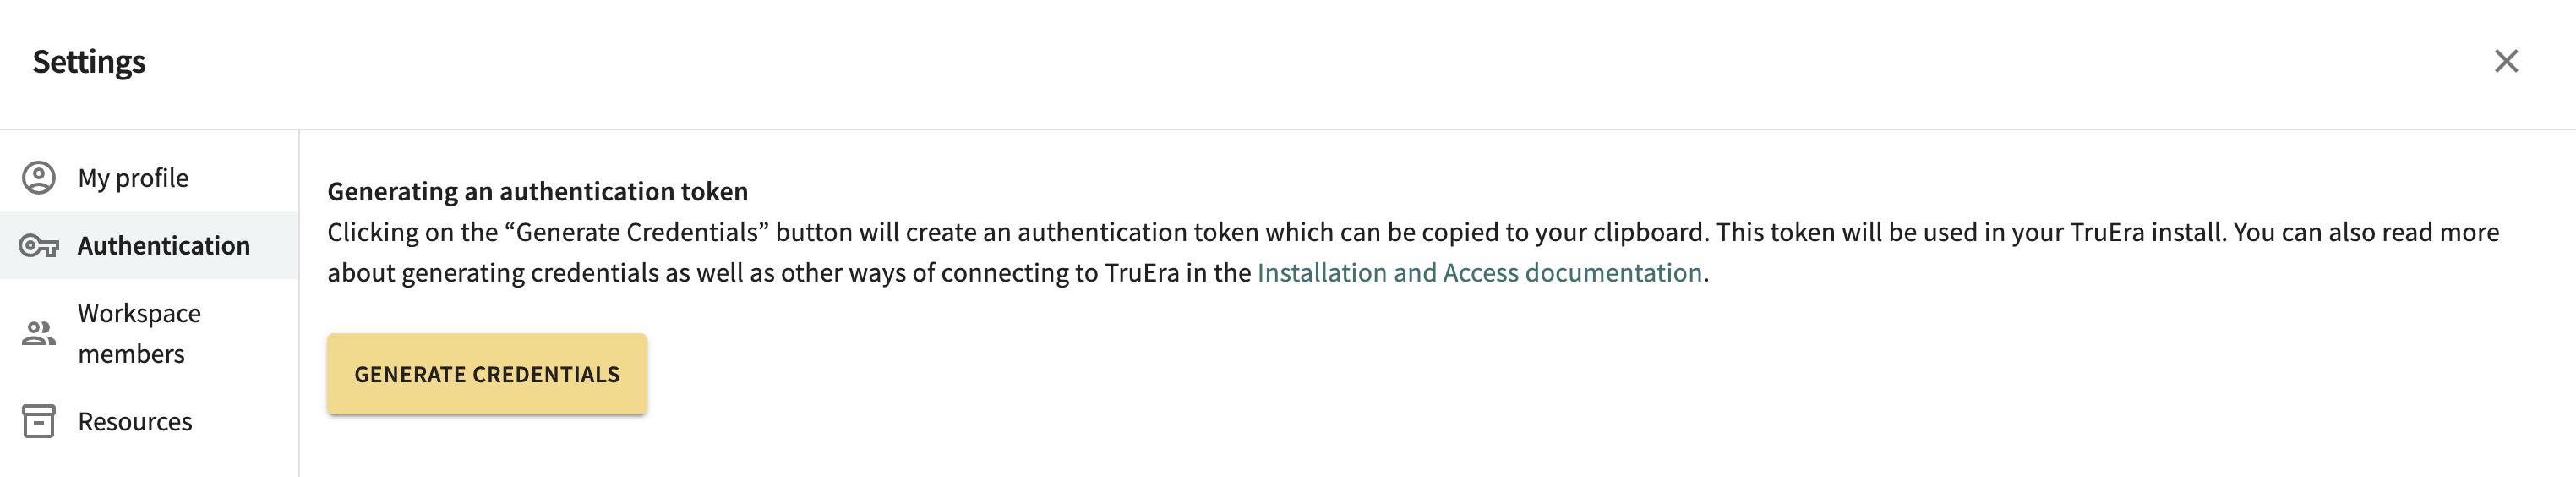

After clicking "Generate Credentials", you will get a pop-up with your authentication token. You can simply click the copy icon to add it to your clipboard. After you've done so, just add it to the cell below along with your TruEra URL.

In [ ]:
# FILL ME!

TRUERA_URL = "https://app.truera.net"
AUTH_TOKEN = ""

### Install a few required packages from pypi. This may take a few minutes.

In [ ]:
! pip install --upgrade truera
! pip install --upgrade shap

In [ ]:
from truera.client.truera_workspace import TrueraWorkspace
from truera.client.truera_authentication import TokenAuthentication

auth = TokenAuthentication(AUTH_TOKEN)
tru = TrueraWorkspace(TRUERA_URL, auth, ignore_version_mismatch=True)

## Step 2: Download sample data
Here we'll use data from scikit-learn's California housing dataset. This can be installed via the `sklearn.datasets` module.

In [ ]:
# Retrieve the data.

# Fetch the data from sklearn
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()

# Format data into a pandas DataFrame
import pandas as pd
feature_col_names = dataset["feature_names"]
label_col_name = dataset["target_names"][0]
XS = dataset["data"]
YS = dataset["target"] 
data = pd.DataFrame(data=XS, columns=feature_col_names)
data[label_col_name] = YS
data["id"] = range(len(data))


## Step 3: Create a project

In [ ]:
tru.set_environment("remote")
tru.add_project("California_Housing", score_type="regression")

## Step 4: Add the data collection and data split
Here we're adding data via simple `pd.DataFrame`s.

In [ ]:
# Ingest data into Truera
from truera.client.ingestion import ColumnSpec

tru.add_data_collection("sklearn_data")


tru.add_data(
    data,
    data_split_name="all",
    column_spec=ColumnSpec(
        id_col_name="id",
        pre_data_col_names=feature_col_names,
        label_col_names=label_col_name
    )
)

## Step 5: Train and add a boosted tree regression model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# instantiate and fit model
gb_model = GradientBoostingRegressor()
gb_model.fit(XS, YS)

We can add the model itself via [`tru.add_python_model()`](python_sdk_reference.md#truera.client.truera_workspace.TrueraWorkspace.add_python_model), which accepts a number of out-of-the box model frameworks.

In [ ]:
# Add to TruEra workspace.

tru.add_python_model("gradient boosted", gb_model)

## Step 6: Upload Predictions

In [ ]:
# Compute predictions
predictions = pd.DataFrame({
    "predictions": gb_model.predict(XS),
    "id": data["id"]
})

# Ingest predictions
tru.add_data(
    predictions,
    data_split_name="all",
    column_spec=ColumnSpec(
        id_col_name="id",
        prediction_col_names="predictions"
    )
)

View the models on the platform! Once you sync to remote using the upload_project(), head over to the web application at the link below to view Influence Sensitivity Plots, use the Test Harness, check out the Model Leaderboard and more!

## Step 7: Upload Influences

In [ ]:
tru.set_model_execution('local')
# Set a background data split for feature influence computations
tru.set_influences_background_data_split("all")
tru.set_influence_type("shap")

# Compute feature influences using SHAP
feature_influences = tru.get_feature_influences()
feature_influences.index.name = "id"
feature_influences.reset_index(inplace=True)

In [ ]:
# Create ModelOutputContext to describe feature influences
from truera.client.ingestion import ModelOutputContext
model_output_context = ModelOutputContext(
    model_name='model 1',           # The model
    score_type='regression',        # Score type of project
    background_split_name='all',    # Background split
    influence_type='kernel-shap'    # Algorithm used to compute influences
)

# Ingest feature influences
from truera.client.ingestion import ModelOutputContext
tru.add_data(
    feature_influences,
    data_split_name="all",
    column_spec=ColumnSpec(
        id_col_name="id",
        feature_influence_col_names=feature_col_names
    ),
    model_output_context=model_output_context
)
